# Import necessary dependencies

In [1]:
## import necessary packages
import numpy as np
import pandas as pd

## visualizations packages
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')

## the magic word for inline visualizations in Jupyter notebook
% matplotlib inline

## import module to process regular expressions
import re

## package to upload and find the stopwords
from nltk.corpus import stopwords

## the list of stopwords to be used
stop = stopwords.words('english')

# Download and Inspect the Raw Data

In [2]:
## read data from the cvs file and save it as a Pandas dataframe 
umobile = pd.read_csv("Amazon_Unlocked_Mobile.csv") 

In [3]:
## option to display full content of columns in the dataframes
pd.set_option('display.max_colwidth', -1)

In [4]:
## preview several lines of the loaded data 
umobile.sample(2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
297333,"POSH MOBILE MICRO X, The Smallest Smartphone in the World, ANDROID UNLOCKED 2.4"" GSM SMARTPHONE with 2MP Camera and 4GB of Storage. 1 Year warranty. (MODEL#: S240 PINK)",Posh Mobile,49.91,5,This is a really good phone for the price,0.0
261604,Nokia 6300 Unlocked Triband Camera Business Phone,NaN,269.10,5,"Good phone and received on time. It is durable, looks prety, I recommend to any one who needs the basic phone.",0.0


In [5]:
## concise summary of the dataframe
umobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
Product Name    413840 non-null object
Brand Name      348669 non-null object
Price           407907 non-null float64
Rating          413840 non-null int64
Reviews         413778 non-null object
Review Votes    401544 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [6]:
## option to limit the display of the columns in the dataframe
pd.set_option('display.max_colwidth', 16)

In [7]:
## descriptive statistics that summarize the central tendency, dispersion and shape of the distribution
round(umobile.describe(include='all'),2)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
count,413840,348669,407907.00,413840.00,413778,401544.00
unique,4410,384,NaN,NaN,162491,NaN
top,Apple iPhone...,Samsung,NaN,NaN,Good,NaN
freq,1451,65747,NaN,NaN,2879,NaN
mean,NaN,NaN,226.87,3.82,NaN,1.51
std,NaN,NaN,273.01,1.55,NaN,9.16
min,NaN,NaN,1.73,1.00,NaN,0.00
25%,NaN,NaN,79.99,3.00,NaN,0.00
50%,NaN,NaN,144.71,5.00,NaN,0.00
75%,NaN,NaN,269.99,5.00,NaN,1.00


In [8]:
## the number of unique values in each column
umobile.nunique()

Product Name      4410
Brand Name         384
Price             1754
Rating               5
Reviews         162491
Review Votes       241
dtype: int64

In [9]:
## the number of missing values in each column
umobile.isnull().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            62
Review Votes    12296
dtype: int64

In [10]:
## the number of non-zero values in each column
umobile.astype(bool).sum(axis=0)

Product Name    413840
Brand Name      413840
Price           413840
Rating          413840
Reviews         413840
Review Votes    135397
dtype: int64

In [11]:
## the distribution of the data based on ranking
umobile.groupby('Rating').size()

Rating
1     72350
2     24728
3     31765
4     61392
5    223605
dtype: int64

# Preliminary cleaning of the data

### Rename the columns

In [12]:
## rename the columns
umobile = umobile.rename(columns=
                    {'Product Name':'name','Brand Name': 'brand','Price':'price',
                    'Rating':'rating', 'Reviews':'review', 'Review Votes':'votes' })

In [13]:
## check for success
umobile.head()

,name,brand,price,rating,review,votes
0,"""CLEAR CLEAN...",Samsung,199.99,5,I feel so LU...,1.0
1,"""CLEAR CLEAN...",Samsung,199.99,4,"nice phone, ...",0.0
2,"""CLEAR CLEAN...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN...",Samsung,199.99,4,It works goo...,0.0
4,"""CLEAR CLEAN...",Samsung,199.99,4,Great phone ...,0.0


### Change some column types 

In [14]:
## change the type of 'rating' to categorical
umobile.rating = umobile.rating.astype('category') 

## change the type of 'votes' to integer, after filling the missing values with 0
umobile.votes = umobile.votes.fillna(0).astype(float)
umobile.votes = umobile.votes.astype(np.int64)

### rewrite the 'price' entries as float with 2 decimals only
umobile.price = umobile.price.round(2)

## check for success
umobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
name      413840 non-null object
brand     348669 non-null object
price     407907 non-null float64
rating    413840 non-null category
review    413778 non-null object
votes     413840 non-null int64
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 16.2+ MB


### Basic cleaning of product names

Numerous entries in the Product Name column refer to other types of products, not necessarily phones, such as phone cases, services or smart watches. I remove some of these entries using several basic steps. 

In [15]:
## look for those strings in product name that do not contain any of the words 'phone', 'unlocked' or 'mobile'
## use lower case representation and record their indices in a list
## many Samsung phones description do not contain any of the above words so I include samsung in the above list

lst1=[]
for i in range(len(umobile)):
    if re.findall(r"\Bone|\Bnlocked|\Bobile|samsung",umobile.name[i].lower()) ==[]:
        lst1.append(i)
len(lst1)

7821

In [16]:
## determine if the product name in lst1 does not contains strings of the form *G or GSM

lst2=[]
for i in lst1:
    if re.findall(r"\BG|GSM",umobile.name[i]) ==[]:
        lst2.append(i)
len(lst2)

3122

In [17]:
## make a copy of the dataframe
df = umobile.copy()

In [18]:
## remove all the entries whose indices are in lst2
df = df.drop(df.index[lst2])

## check for success
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410718 entries, 0 to 413839
Data columns (total 6 columns):
name      410718 non-null object
brand     347204 non-null object
price     404968 non-null float64
rating    410718 non-null category
review    410660 non-null object
votes     410718 non-null int64
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 19.2+ MB


### Basic cleaning of the brand names

In [19]:
## a second look at the brand list, lower case all brand names
df.brand=df.brand.str.lower()

## write brand names as a list with nonrepeated entries
brand_list = list(set(df.brand))
brand_list[10:15]

['alcatel', 'kingzone', 'blackphone', 'sole mobile', 'asus']

In [20]:
## find those brands that refer to cases and other accesories
## most of them contain some version of the word box

boxes=[]
for i in range(1, len(brand_list)):
    if re.findall(r"\Box", brand_list[i]) != []:
        boxes.append(brand_list[i])
boxes

['lightinthebox',
 'moxee technologies',
 'concox',
 'otterbox',
 'ultrabox',
 'powermoxie']

In [21]:
## remove the entries corresponding to the brands listed in boxes
df = df[~df.brand.isin(boxes)]

## check for success
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401827 entries, 0 to 413839
Data columns (total 6 columns):
name      401827 non-null object
brand     338313 non-null object
price     396077 non-null float64
rating    401827 non-null category
review    401771 non-null object
votes     401827 non-null int64
dtypes: category(1), float64(1), int64(1), object(3)
memory usage: 18.8+ MB


### Remove the entries with no reviews

In [22]:
## remove those entries that have empty reviews
df=df.dropna(subset=['review'])

In [23]:
## check for success
df.isnull().sum()

name          0
brand     63501
price      5747
rating        0
review        0
votes         0
dtype: int64

In [24]:
## the number of unique values in each column of the trimmed dataset
df.nunique()

name        4259
brand        306
price       1708
rating         5
review    155817
votes        241
dtype: int64

# Analysis of Data Features

## One Feature Analysis

### Distribution by Brand

The initial dataset contains 384 distinct brand names, also there are 63501 missing brand records. After rewriting all the brands as lower case and removing records for some brands that is easy to determine do correspond to mobile phones, there are 306 brands left.  

In [25]:
## the 10 most numerous brands 
df_brand=df.groupby(['brand'])['brand'].count().nlargest(10) 

## the percentage of records that correspond to the 10 most numerous brands
print(df_brand)

print('The 10 most numerous brands account for about {}% of the total records.'.format(round(df_brand.sum()/len(df) * 100),0))

brand
samsung       68697
blu           63254
apple         57454
lg            22395
blackberry    17865
nokia         16814
motorola      13330
htc           12887
cnpgd         12613
sony           7891
Name: brand, dtype: int64
The 10 most numerous brands account for about 73.0% of the total records.


This list is dominated by Samsung, Blu and Apple.

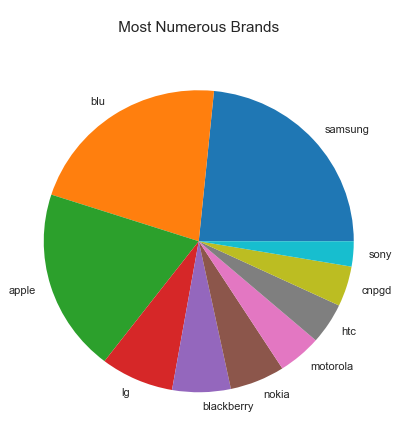

In [26]:
## pie chart for distribution of the 10 most numerous brands 

## create the figure in which the chart will be drawn
plt.figure(figsize=(10, 10), dpi=50, linewidth=2, frameon=True)

## the pie chart
df_brand.plot(kind='pie', fontsize=16)
plt.ylabel('')

## the title
plt.title('\n Most Numerous Brands \n', fontsize=22)

plt.show()

### Descriptive Statistics for Price

In [27]:
print(round(df.price.describe(),2))

count    396024.00
mean        230.61
std         272.78
min           2.29
25%          83.50
50%         149.99
75%         276.37
max        2598.00
Name: price, dtype: float64


### Distribution by Rating

In [28]:
## distribution by rating: numerical information
df.groupby(['rating']).count()

,name,brand,price,review,votes
rating,,,,,
1,71154,59684,69740,71154,71154
2,24255,20717,23797,24255,24255
3,31051,26686,30464,31051,31051
4,59892,51221,59054,59892,59892
5,215419,179962,212969,215419,215419


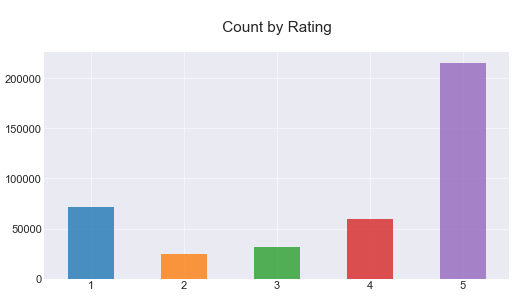

In [29]:
## create a bar chart for the rating counts

## the figure in which the chart will be drawn
plt.figure(figsize=(12,6), dpi=50, linewidth=2, frameon=True)

## the bar chart
count_by_rating = df.rating.value_counts().loc[[1, 2, 3, 4, 5]]
count_by_rating.plot(kind='bar', alpha=.8)

## the title
plt.title('\n Count by Rating \n', fontsize=22)

## set x-axis interval, labels and ticks
plt.xticks(fontsize=16, rotation=0)

## set the location and labels of yticks
plt.yticks(fontsize = 16)

plt.show()


The dataset is highly unbalanced, most of the products receive 5 star ratings, followed by 1 star ratings. In fact, the 5 star ratings account for half of the data.  

### Review Length Analysis

In [30]:
## create a dataframe that contains the review length
revl = pd.DataFrame(df.review.str.len())

## descriptive statistics of the review length
revl.describe().round(0)

,review
count,401771.0
mean,219.0
std,468.0
min,1.0
25%,28.0
50%,94.0
75%,225.0
max,29419.0


In [31]:
## bin edges that will be used to group the review length data
bin_cuts = [ 0, 10, 100, 1000, 10000, 30000] 

## labels for the five groups of review lengths
bin_names = [ 'vshort', 'short', 'medium' ,'long', 'vlong' ]

## create length levels column, call it 'length'
revl['length'] = pd.cut(revl.review, bin_cuts, labels=bin_names)

In [32]:
## change the type of 'length' to categorical in revl
revl['length']= revl['length'].astype('category') 

In [33]:
## counts in each bin of review length
bin_values = revl.groupby(['length']).count()
bin_values = list(bin_values['review'])

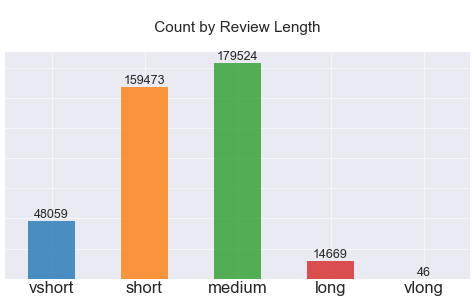

In [34]:
## create a bar chart for the review length counts

## the figure in which the chart will be drawn
plt.figure(figsize=(12,6), dpi=50, linewidth=2, frameon=True)

## the bar chart
count_by_length = revl['length'].value_counts().loc[bin_names]
ax=count_by_length.plot(kind='bar', alpha=.8)

## the title
ax.set_title('\n Count by Review Length \n', fontsize=22)

## set x-axis interval, labels and ticks
ax.set_xticklabels(bin_names, rotation=0, fontsize=24)

## set y-axis labels
ax.set_yticklabels([], fontsize=24)

## label the bars by frequency
for xlabel, ylabel in zip(ax.patches, bin_values):
    height = xlabel.get_height()
    ax.text(xlabel.get_x() + xlabel.get_width()/2, height + 6, ylabel,
            ha='center', va='bottom', fontsize=18)

plt.show()


In [35]:
## dataframe that contains the very short reviews only
revl_vshort=revl[revl['length']=='vshort']
revl_vshort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48059 entries, 39 to 413836
Data columns (total 2 columns):
review    48059 non-null int64
length    48059 non-null category
dtypes: category(1), int64(1)
memory usage: 798.0 KB


In [36]:
## list of counts grouped by review length, for reviews up to 10 characters
rls=revl_vshort.groupby(['review']).count()
ylist=rls['length'].tolist()
ylist

[259, 1894, 577, 7901, 3327, 2096, 4673, 5681, 16121, 5530]

<Figure size 600x300 with 0 Axes>

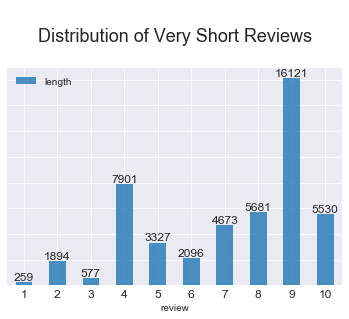

In [37]:
## create a bar chart for the very short review counts

## the figure in which the chart will be drawn
plt.figure(figsize=(12,6), dpi=50, linewidth=2, frameon=True)

## the bar chart
ax=rls.plot(kind='bar', alpha=.8)

## the title
ax.set_title('\n Distribution of Very Short Reviews \n', fontsize=18)

## create list of labels for the bar chart
xlist = list(range(1,11))

## set x-axis interval, labels and ticks
ax.set_xticklabels(xlist, fontsize=12, rotation=0)

## set y-axis interval, labels and ticks
ax.set_yticklabels([], fontsize=16)

## label the bars by frequency
for xlabel, ylabel in zip(ax.patches, ylist):
    height = xlabel.get_height()
    ax.text(xlabel.get_x() + xlabel.get_width()/2, height + 6, ylabel,
            ha='center', va='bottom', fontsize=12)

plt.show()

### Analysis of Number of Votes

In [38]:
## descriptive statistics of the number of votes per review
print(round(df.votes.describe(),0))

count    401771.0
mean          1.0
std           9.0
min           0.0
25%           0.0
50%           0.0
75%           1.0
max         645.0
Name: votes, dtype: float64


In [39]:
## number of reviews with more than 30 votes
len(df[df['votes'] > 30]) 

3010

In [40]:
## number of reviews that receive 0 or 1 votes
len(df[df['votes'] < 2]) 

336748

### Reflections

Most of the reviews receive at most one vote. Only 3010 reviews receive more than 30 votes. This feature does not seem relevant in distinguishing properties of the data.

## Relations between Features

### The relations between price and brand, price and rating 

In [41]:
## get the mean 'price' by 'brand'
brand_info = df.groupby(['brand'], as_index=False)['price','rating'].mean().round(2)

## sort the entries in decreasing order of mean 'price'
brand_info.sort_values(['price'], ascending=False).head(10)

,brand,price
107,iridium,1531.00
164,mtm trading llc,1300.00
79,google pixel,827.75
25,bluecosmo,734.00
207,s7 active,724.99
6,"amazon.com, ...",674.76
212,samsung inte...,673.99
232,silent circle,632.34
227,shenzhen sno...,613.00
138,lenovo,609.67


In [42]:
## the average price for the most numerous brands

dfm = df.groupby('brand') \
       .agg({'brand':'count', 'price':'mean'}) \
       .rename(columns={'brand':'count','price':'mean_price'}) \
       .reset_index()
dfm_sorted = dfm.sort_values(by='count', ascending=False).head(10).round(2)
dfm_sorted

,brand,count,mean_price
209,samsung,68697,294.47
22,blu,63254,245.40
9,apple,57454,305.95
141,lg,22395,207.94
18,blackberry,17865,90.81
168,nokia,16814,153.90
162,motorola,13330,151.89
93,htc,12887,160.80
40,cnpgd,12613,52.01
239,sony,7891,305.78


In [43]:
### get the mean 'price' by 'rating'
price_rating = df.groupby(['rating'], as_index=False)['price'].mean().round(2)
price_rating

,rating,price
0,1,203.34
1,2,195.59
2,3,186.87
3,4,214.48
4,5,254.18


### Review Length versus Price and Brand

In [44]:
## create a column that contains the length of each review
df['revl'] = df['review'].str.len()

## check for success
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401771 entries, 0 to 413839
Data columns (total 7 columns):
name      401771 non-null object
brand     338270 non-null object
price     396024 non-null float64
rating    401771 non-null category
review    401771 non-null object
votes     401771 non-null int64
revl      401771 non-null int64
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 21.8+ MB


In [45]:
## the average review length by brand
rev_brand = df.groupby(['brand'], as_index=False)['revl'].mean().round(2)

## sort the entries in decreasing order of mean 'revl'
rev_brand.sort_values(['revl'], ascending=False).head(10)

,brand,revl
41,conquest s8 ...,3222.00
186,peek,3194.29
137,leeco,2437.00
71,geekera,1412.50
113,jhm,1264.00
92,hp handheld,1171.19
73,getnord,1168.20
115,jiayu,1035.00
232,silent circle,921.75
135,lber,913.33


In [46]:
## average values for the most numerous brands
dfrev = df.groupby('brand') \
       .agg({'brand':'count', 'revl':'mean', 'price':'mean'}) \
       .rename(columns={'brand':'count','revl':'mean_length', 'price':'mean_price'}) \
       .reset_index()
dfrev_sorted = dfrev.sort_values(by='count', ascending=False).head(10).round(2)
dfrev_sorted

,brand,count,mean_length,mean_price
209,samsung,68697,188.35,294.47
22,blu,63254,228.10,245.40
9,apple,57454,132.33,305.95
141,lg,22395,215.85,207.94
18,blackberry,17865,207.67,90.81
168,nokia,16814,371.18,153.90
162,motorola,13330,276.03,151.89
93,htc,12887,227.87,160.80
40,cnpgd,12613,193.02,52.01
239,sony,7891,364.99,305.78


### Ratings vs. Review Length and Price

In [47]:
## average review length and average price by rating

dfrate = df.groupby('rating') \
       .agg({'revl':'mean', 'price':'mean'}) \
       .rename(columns={'revl':'mean_length','price':'mean_price'}) \
       .reset_index()
dfrate.round(2)

,rating,mean_length,mean_price
0,1,245.20,203.34
1,2,327.70,195.59
2,3,299.15,186.87
3,4,276.07,214.48
4,5,170.30,254.18


# Data Binning

#### Remove all the 3 star ratings records.

In [48]:
## drop all the entries where rating is 3
df = df[df.rating !=3]

## check for success
df.nunique()

name        4228
brand        304
price       1697
rating         4
review    141984
votes        232
revl        3291
dtype: int64

#### Create a new categorical feature with 2 bins: 0(1,2 rating) and 1(4,5 rating)

In [49]:
## create a column 'feel' with default value 0
df['feel']= 0

## check for success
df.head(2)

,name,brand,price,rating,review,votes,revl,feel
0,"""CLEAR CLEAN...",samsung,199.99,5,I feel so LU...,1,374,0
1,"""CLEAR CLEAN...",samsung,199.99,4,"nice phone, ...",0,214,0


In [50]:
## change the value of 'feel' to 1 if the rating is 4 or 5
df.loc[(df['rating'] == 4),  ['feel']] =1
df.loc[(df['rating'] == 5),  ['feel']] =1

## check for success
df.nunique()

name        4228
brand        304
price       1697
rating         4
review    141984
votes        232
revl        3291
feel           2
dtype: int64

In [51]:
## change the type of 'feel' to category
df['feel'] = df['feel'].astype('category') 

## check for success
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370720 entries, 0 to 413839
Data columns (total 8 columns):
name      370720 non-null object
brand     311584 non-null object
price     365560 non-null float64
rating    370720 non-null category
review    370720 non-null object
votes     370720 non-null int64
revl      370720 non-null int64
feel      370720 non-null category
dtypes: category(2), float64(1), int64(2), object(3)
memory usage: 20.5+ MB


In [52]:
## reindex thedataframe
df = df.reset_index(drop=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370720 entries, 0 to 370719
Data columns (total 8 columns):
name      370720 non-null object
brand     311584 non-null object
price     365560 non-null float64
rating    370720 non-null category
review    370720 non-null object
votes     370720 non-null int64
revl      370720 non-null int64
feel      370720 non-null category
dtypes: category(2), float64(1), int64(2), object(3)
memory usage: 17.7+ MB


## Store the Prepared Data

In [54]:
# store the processed dataframe as a csv file
df.to_csv('mobile_phones_prepared.csv', index=False)

## Upload the Prepared Data

In [55]:
## read data from the cvs file and save it as a Pandas dataframe 
mobile = pd.read_csv('mobile_phones_prepared.csv') 

## check the dataframe
mobile.head()

,name,brand,price,rating,review,votes,revl,feel
0,"""CLEAR CLEAN...",samsung,199.99,5,I feel so LU...,1,374,1
1,"""CLEAR CLEAN...",samsung,199.99,4,"nice phone, ...",0,214,1
2,"""CLEAR CLEAN...",samsung,199.99,5,Very pleased,0,12,1
3,"""CLEAR CLEAN...",samsung,199.99,4,It works goo...,0,76,1
4,"""CLEAR CLEAN...",samsung,199.99,4,Great phone ...,0,223,1


# Basic Text Features Extraction and Analysis

These steps follow the examples from  [Ultimate guide to deal with the text data](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/) and [Machine Learning - Text Processing](https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958). 

In [56]:
## create a copy of the dataset
mobile_clean=mobile.copy()

## drop columns 'name', 'brand' and 'price'
mobile_clean = mobile_clean.drop(['name', 'brand', 'price'], axis=1)

## create a column that gives the number of words in review
mobile_clean['nr_words'] = mobile_clean['review'].apply(lambda x: len(str(x).split(' ')))

## find number of stopwords per review and record it in 'swords'
mobile_clean['swords'] = mobile_clean['review'].apply(lambda x: len([x for x in x.split() if x in stop]))

## record the numbers of special characters in a column 'nr_special'
mobile_clean['nr_special'] = mobile_clean['review'].apply(lambda x: len(x) - len(re.sub("[^a-zA-Z]+"," ", x)))

## create a new column 'nr_upper' to record the number of words written in uppercase
mobile_clean['nr_upper'] = mobile_clean.review.apply(lambda x: len([x for x in x.split() if x.isupper()]))

## descriptive statistics of the data
round(mobile_clean.describe(), 2)

,rating,votes,revl,feel,nr_words,swords,nr_special,nr_upper
count,370720.00,370720.00,370720.00,370720.00,370720.00,370720.00,370720.00,370720.00
mean,3.87,1.50,212.06,0.74,39.58,15.83,6.60,2.13
std,1.60,9.17,458.89,0.44,84.37,35.19,19.23,6.35
min,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
25%,2.00,0.00,26.00,0.00,5.00,1.00,0.00,0.00
50%,5.00,0.00,89.00,1.00,17.00,6.00,2.00,0.00
75%,5.00,1.00,217.00,1.00,41.00,17.00,6.00,2.00
max,5.00,645.00,29419.00,1.00,5313.00,2228.00,1917.00,496.00


In [57]:
## option to display full content of columns in the dataframes
pd.set_option('display.max_colwidth', -1)

In [58]:
## preview the prepared dataset augumented with the numerical features
mobile_clean.sample(4)

,rating,review,votes,revl,feel,nr_words,swords,nr_special,nr_upper
86944,4,"Compre este producto porque ya estaba recomendado por otros y ademas funcionaria ien en mi pais que es venezuela estoy aprendiendo a utilizarlo pero llego en perfecto estado no le falto nada, con su caja , el manos libre, cd y un manual de bolsillo su cable de conexion. Muchas gracias estoy complacidade haber comprado este producto.",3,334,1,57,4,5,0
237890,1,I tried to order the correct phone twice and both times it came in with a TMobile connection. There was a message that refused to be deleted. The ad didn't say anything about this. I am an ATT customer and the phone is advertised as being compatible.,4,250,0,47,22,3,3
17026,1,I am not happy with my purchase at all. The phone dies at 56% every day. I can not get the company I purchased it from to call me back!,0,135,0,30,13,6,3
139547,5,"After 2 months I decided it was exactly what I was looking for... Well for a cheap price. My phone of three years was ready to rest for a while so I decided to look into this product because I'm a lover of photography, (but extremely poor) but this camera is incredible. Much better than the iPhone 6 and 6+! It has a long lasting battery. I listen to music up to 9 hours of my day on Google Play music and even after I get home around 6 it still has 20+ percentage left! Very happy with this phone.",0,499,1,100,39,26,5
